# Pandas support

<div class="alert alert-warning">

**Warning:** pandas support is currently experimental, don't expect everything to work.

</div>

It is convenient to use the Pandas package when dealing with numerical data, so Pint provides PintArray. A PintArray is a Pandas Extension Array, which allows Pandas to recognise the Quantity and store it in Pandas DataFrames and Series.

## Installation


Pandas support is provided by the `pint-pandas` package. To install it use either:
```
python -m pip install pint-pandas
```
Or:
```
conda install -c conda-forge pint-pandas
```

## Basic example

This example will show the simplist way to use pandas with pint and the underlying objects. It's slightly fiddly as you are not reading from a file. A more normal use case is given in Reading a csv.

First some imports

In [1]:
import pandas as pd 
import pint
import pint_pandas
pint_pandas.show_versions()

{'numpy': '1.18.5',
 'pandas': '1.4.0',
 'pint': '0.18',
 'pint_pandas': '0.3.dev55+g2f530f4'}


Next, we create a DataFrame with PintArrays as columns.

In [2]:
df = pd.DataFrame({
    "torque": pd.Series([1., 2., 2., 3.], dtype="pint[lbf ft]"),
    "angular_velocity": pd.Series([1., 2., 2., 3.], dtype="pint[rpm]"),
})
df

,torque,angular_velocity
0,1.0,1.0
1,2.0,2.0
2,2.0,2.0
3,3.0,3.0


Operations with columns are units aware so behave as we would intuitively expect.

In [3]:
df['power'] = df['torque'] * df['angular_velocity']
df

,torque,angular_velocity,power
0,1.0,1.0,1.0
1,2.0,2.0,4.0
2,2.0,2.0,4.0
3,3.0,3.0,9.0


We can see the columns' units in the dtypes attribute

In [4]:
df.dtypes

torque                                       pint[foot * force_pound]
angular_velocity                         pint[revolutions_per_minute]
power               pint[foot * force_pound * revolutions_per_minute]
dtype: object

Each column can be accessed as a Pandas Series

In [5]:
df.pint.dequantify()

,torque,angular_velocity,power
unit,foot * force_pound,revolutions_per_minute,foot * force_pound * revolutions_per_minute
0,1.0,1.0,1.0
1,2.0,2.0,4.0
2,2.0,2.0,4.0
3,3.0,3.0,9.0


In [6]:
df.power

0    1.0
1    4.0
2    4.0
3    9.0
Name: power, dtype: pint[foot * force_pound * revolutions_per_minute]

Which contains a PintArray

In [7]:
df.power.values

<PintArray>
[1.0, 4.0, 4.0, 9.0]
Length: 4, dtype: pint[foot * force_pound * revolutions_per_minute]

The PintArray contains a Quantity

In [8]:
df.power.values.quantity

Magnitude,[1.0 4.0 4.0 9.0]
Units,foot force_pound revolutions_per_minute


Pandas Series accessors are provided for most Quantity properties and methods, which will convert the result to a Series where possible.

In [9]:
df.power.pint.units

<Unit('foot * force_pound * revolutions_per_minute')>

In [10]:
df.power.pint.to("kW").values

<PintArray>
[0.00014198092353610379,  0.0005679236941444151,  0.0005679236941444151,
   0.001277828311824934]
Length: 4, dtype: pint[kilowatt]

## Reading from csv

Reading from files is the far more standard way to use pandas. To facilitate this, DataFrame accessors are provided to make it easy to get to PintArrays. 

In [11]:
import pandas as pd 
import pint
import pint_pandas
import io

Here's the contents of the csv file.

In [12]:
test_data = '''ShaftSpeedIndex,rpm,1200,1200,1200,1600,1600,1600,2300,2300,2300
pump,,A,B,C,A,B,C,A,B,C
ShaftSpeed,rpm,1200,1200,1200,1600,1600,1600,2300,2300,2300
FlowRate,m^3 h^-1,8.72,9.28,9.31,11.61,12.78,13.51,18.32,17.90,19.23
DifferentialPressure,kPa,162.03,144.16,136.47,286.86,241.41,204.21,533.17,526.74,440.76
ShaftPower,kW,1.32,1.23,1.18,3.09,2.78,2.50,8.59,8.51,7.61
Efficiency,dimensionless,30.60,31.16,30.70,30.72,31.83,31.81,32.52,31.67,32.05'''

Let's read that into a DataFrame.
Here io.StringIO is used in place of reading a file from disk, whereas a csv file path would typically be used and is shown commented.

In [13]:
df = pd.read_csv(io.StringIO(test_data), header=[0, 1], index_col = [0,1]).T
# df = pd.read_csv("/path/to/test_data.csv", header=[0, 1])
df

ShaftSpeed FlowRate DifferentialPressure ShaftPower  \
                            rpm m^3 h^-1                  kPa         kW   
ShaftSpeedIndex pump                                                       
1200            A        1200.0     8.72               162.03       1.32   
                B        1200.0     9.28               144.16       1.23   
                C        1200.0     9.31               136.47       1.18   
1600            A        1600.0    11.61               286.86       3.09   
                B        1600.0    12.78               241.41       2.78   
                C        1600.0    13.51               204.21       2.50   
2300            A        2300.0    18.32               533.17       8.59   
                B        2300.0    17.90               526.74       8.51   
                C        2300.0    19.23               440.76       7.61   

                        Efficiency  
                     dimensionless  
ShaftSpeedIndex pump                
1200            A            30.60  
                B            31.16  
                C            30.70  
1600            A            30.72  
                B            31.83  
                C            31.81  
2300            A            32.52  
                B            31.67  
                C            32.05

Then use the DataFrame's pint accessor's quantify method to convert the columns from `np.ndarray`s to PintArrays, with units from the bottom column level.

In [14]:
df.dtypes

ShaftSpeed            rpm              float64
FlowRate              m^3 h^-1         float64
DifferentialPressure  kPa              float64
ShaftPower            kW               float64
Efficiency            dimensionless    float64
dtype: object

In [15]:
df_ = df.pint.quantify(level=-1)
df_

ShaftSpeed FlowRate DifferentialPressure ShaftPower  \
ShaftSpeedIndex pump                                                       
1200            A        1200.0     8.72               162.03       1.32   
                B        1200.0     9.28               144.16       1.23   
                C        1200.0     9.31               136.47       1.18   
1600            A        1600.0    11.61               286.86       3.09   
                B        1600.0    12.78               241.41       2.78   
                C        1600.0    13.51               204.21        2.5   
2300            A        2300.0    18.32               533.17       8.59   
                B        2300.0     17.9               526.74       8.51   
                C        2300.0    19.23               440.76       7.61   

                     Efficiency  
ShaftSpeedIndex pump             
1200            A          30.6  
                B         31.16  
                C          30.7  
1600            A         30.72  
                B         31.83  
                C         31.81  
2300            A         32.52  
                B         31.67  
                C         32.05

Let's confirm the units have been parsed correctly

In [16]:
df_.dtypes

ShaftSpeed                    pint[revolutions_per_minute]
FlowRate                pint[meter ** 3 / planck_constant]
DifferentialPressure                      pint[kilopascal]
ShaftPower                                  pint[kilowatt]
Efficiency                             pint[dimensionless]
dtype: object

Here the h in m^3 h^-1 has been parsed as the planck constant. Let's change the unit to hours.

In [17]:
df_['FlowRate'] = pint_pandas.PintArray(df_['FlowRate'].values.quantity.m, dtype = "pint[m^3/hr]")
df_.dtypes

ShaftSpeed              pint[revolutions_per_minute]
FlowRate                     pint[meter ** 3 / hour]
DifferentialPressure                pint[kilopascal]
ShaftPower                            pint[kilowatt]
Efficiency                       pint[dimensionless]
dtype: object

As previously, operations between DataFrame columns are unit aware

In [18]:
df_.ShaftPower / df_.ShaftSpeed

ShaftSpeedIndex  pump
1200             A                      0.0011
                 B                    0.001025
                 C       0.0009833333333333332
1600             A       0.0019312499999999998
                 B                   0.0017375
                 C                   0.0015625
2300             A        0.003734782608695652
                 B       0.0036999999999999997
                 C       0.0033086956521739133
dtype: pint[kilowatt / revolutions_per_minute]

In [19]:
df_['ShaftTorque'] = df_.ShaftPower / df_.ShaftSpeed
df_['FluidPower'] = df_['FlowRate'] * df_['DifferentialPressure']
df_

ShaftSpeed FlowRate DifferentialPressure ShaftPower  \
ShaftSpeedIndex pump                                                       
1200            A        1200.0     8.72               162.03       1.32   
                B        1200.0     9.28               144.16       1.23   
                C        1200.0     9.31               136.47       1.18   
1600            A        1600.0    11.61               286.86       3.09   
                B        1600.0    12.78               241.41       2.78   
                C        1600.0    13.51               204.21        2.5   
2300            A        2300.0    18.32               533.17       8.59   
                B        2300.0     17.9               526.74       8.51   
                C        2300.0    19.23               440.76       7.61   

                     Efficiency            ShaftTorque          FluidPower  
ShaftSpeedIndex pump                                                        
1200            A          30.6                 0.0011  1412.9016000000001  
                B         31.16               0.001025           1337.8048  
                C          30.7  0.0009833333333333332  1270.5357000000001  
1600            A         30.72  0.0019312499999999998           3330.4446  
                B         31.83              0.0017375           3085.2198  
                C         31.81              0.0015625           2758.8771  
2300            A         32.52   0.003734782608695652           9767.6744  
                B         31.67  0.0036999999999999997   9428.645999999999  
                C         32.05  0.0033086956521739133           8475.8148

The DataFrame's `pint.dequantify` method then allows us to retrieve the units information as a header row once again.

In [20]:
df_.pint.dequantify()

ShaftSpeed          FlowRate  \
unit                 revolutions_per_minute meter ** 3 / hour   
ShaftSpeedIndex pump                                            
1200            A                    1200.0              8.72   
                B                    1200.0              9.28   
                C                    1200.0              9.31   
1600            A                    1600.0             11.61   
                B                    1600.0             12.78   
                C                    1600.0             13.51   
2300            A                    2300.0             18.32   
                B                    2300.0             17.90   
                C                    2300.0             19.23   

                     DifferentialPressure ShaftPower    Efficiency  \
unit                           kilopascal   kilowatt dimensionless   
ShaftSpeedIndex pump                                                 
1200            A                  162.03       1.32         30.60   
                B                  144.16       1.23         31.16   
                C                  136.47       1.18         30.70   
1600            A                  286.86       3.09         30.72   
                B                  241.41       2.78         31.83   
                C                  204.21       2.50         31.81   
2300            A                  533.17       8.59         32.52   
                B                  526.74       8.51         31.67   
                C                  440.76       7.61         32.05   

                                           ShaftTorque  \
unit                 kilowatt / revolutions_per_minute   
ShaftSpeedIndex pump                                     
1200            A                             0.001100   
                B                             0.001025   
                C                             0.000983   
1600            A                             0.001931   
                B                             0.001737   
                C                             0.001563   
2300            A                             0.003735   
                B                             0.003700   
                C                             0.003309   

                                         FluidPower  
unit                 kilopascal * meter ** 3 / hour  
ShaftSpeedIndex pump                                 
1200            A                         1412.9016  
                B                         1337.8048  
                C                         1270.5357  
1600            A                         3330.4446  
                B                         3085.2198  
                C                         2758.8771  
2300            A                         9767.6744  
                B                         9428.6460  
                C                         8475.8148

This allows for some rather powerful abilities. For example, to change single column units

In [21]:
df_['FluidPower'] = df_['FluidPower'].pint.to("kW")
df_['FlowRate'] = df_['FlowRate'].pint.to("L/s")
df_['ShaftTorque'] = df_['ShaftTorque'].pint.to("N m")
df_.pint.dequantify()

ShaftSpeed       FlowRate  \
unit                 revolutions_per_minute liter / second   
ShaftSpeedIndex pump                                         
1200            A                    1200.0       2.422222   
                B                    1200.0       2.577778   
                C                    1200.0       2.586111   
1600            A                    1600.0       3.225000   
                B                    1600.0       3.550000   
                C                    1600.0       3.752778   
2300            A                    2300.0       5.088889   
                B                    2300.0       4.972222   
                C                    2300.0       5.341667   

                     DifferentialPressure ShaftPower    Efficiency  \
unit                           kilopascal   kilowatt dimensionless   
ShaftSpeedIndex pump                                                 
1200            A                  162.03       1.32         30.60   
                B                  144.16       1.23         31.16   
                C                  136.47       1.18         30.70   
1600            A                  286.86       3.09         30.72   
                B                  241.41       2.78         31.83   
                C                  204.21       2.50         31.81   
2300            A                  533.17       8.59         32.52   
                B                  526.74       8.51         31.67   
                C                  440.76       7.61         32.05   

                        ShaftTorque FluidPower  
unit                 meter * newton   kilowatt  
ShaftSpeedIndex pump                            
1200            A         10.504226   0.392473  
                B          9.788029   0.371612  
                C          9.390142   0.352927  
1600            A         18.442079   0.925123  
                B         16.591903   0.857005  
                C         14.920776   0.766355  
2300            A         35.664547   2.713243  
                B         35.332397   2.619068  
                C         31.595716   2.354393

The units are harder to read than they need be, so lets change pints default format for displaying units.

In [22]:
pint_pandas.PintType.ureg.default_format = "P~"
df_.pint.dequantify()

ShaftSpeed  FlowRate DifferentialPressure ShaftPower  \
unit                        rpm       l/s                  kPa         kW   
ShaftSpeedIndex pump                                                        
1200            A        1200.0  2.422222               162.03       1.32   
                B        1200.0  2.577778               144.16       1.23   
                C        1200.0  2.586111               136.47       1.18   
1600            A        1600.0  3.225000               286.86       3.09   
                B        1600.0  3.550000               241.41       2.78   
                C        1600.0  3.752778               204.21       2.50   
2300            A        2300.0  5.088889               533.17       8.59   
                B        2300.0  4.972222               526.74       8.51   
                C        2300.0  5.341667               440.76       7.61   

                     Efficiency ShaftTorque FluidPower  
unit                                    N·m         kW  
ShaftSpeedIndex pump                                    
1200            A         30.60   10.504226   0.392473  
                B         31.16    9.788029   0.371612  
                C         30.70    9.390142   0.352927  
1600            A         30.72   18.442079   0.925123  
                B         31.83   16.591903   0.857005  
                C         31.81   14.920776   0.766355  
2300            A         32.52   35.664547   2.713243  
                B         31.67   35.332397   2.619068  
                C         32.05   31.595716   2.354393

or the entire table's units

In [36]:
df_.pint.to_base_units().pint.dequantify()

ShaftSpeed            FlowRate  \
unit                 radian / second meter ** 3 / second   
ShaftSpeedIndex pump                                       
1200            A         125.663706            0.002422   
                B         125.663706            0.002578   
                C         125.663706            0.002586   
1600            A         167.551608            0.003225   
                B         167.551608            0.003550   
                C         167.551608            0.003753   
2300            A         240.855437            0.005089   
                B         240.855437            0.004972   
                C         240.855437            0.005342   

                               DifferentialPressure  \
unit                 kilogram / meter / second ** 2   
ShaftSpeedIndex pump                                  
1200            A                          162030.0   
                B                          144160.0   
                C                          136470.0   
1600            A                          286860.0   
                B                          241410.0   
                C                          204210.0   
2300            A                          533170.0   
                B                          526740.0   
                C                          440760.0   

                                              ShaftPower    Efficiency  \
unit                 kilogram * meter ** 2 / second ** 3 dimensionless   
ShaftSpeedIndex pump                                                     
1200            A                                 1320.0         30.60   
                B                                 1230.0         31.16   
                C                                 1180.0         30.70   
1600            A                                 3090.0         30.72   
                B                                 2780.0         31.83   
                C                                 2500.0         31.81   
2300            A                                 8590.0         32.52   
                B                                 8510.0         31.67   
                C                                 7610.0         32.05   

                                             ShaftTorque  \
unit                 kilogram * meter ** 2 / second ** 2   
ShaftSpeedIndex pump                                       
1200            A                              10.504226   
                B                               9.788029   
                C                               9.390142   
1600            A                              18.442079   
                B                              16.591903   
                C                              14.920776   
2300            A                              35.664547   
                B                              35.332397   
                C                              31.595716   

                                              FluidPower  
unit                 kilogram * meter ** 2 / second ** 3  
ShaftSpeedIndex pump                                      
1200            A                             392.472667  
                B                             371.612444  
                C                             352.926583  
1600            A                             925.123500  
                B                             857.005500  
                C                             766.354750  
2300            A                            2713.242889  
                B                            2619.068333  
                C                            2354.393000

## Plotting
Pint's matplotlib support allows columns with the same dimensionality to be plotted.

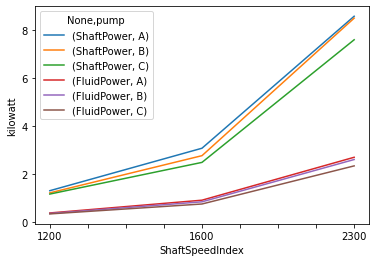

In [37]:
pint_pandas.PintType.ureg.setup_matplotlib()
ax = df_[['ShaftPower', 'FluidPower']].unstack("pump").plot()

In [38]:
ax.yaxis.units

<Unit('kilowatt')>

Note that indexes cannot store PintArrays, so don't contain unit information

In [39]:
print(ax.xaxis.units)

None


## Advanced example
This example shows alternative ways to use pint with pandas and other features.

Start with the same imports.

In [40]:
import pandas as pd 
import pint
import pint_pandas

We'll be use a shorthand for PintArray

In [41]:
PA_ = pint_pandas.PintArray

And set up a unit registry and quantity shorthand.

In [42]:
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

Operations between PintArrays of different unit registry will not work. We can change the unit registry that will be used in creating new PintArrays to prevent this issue.

In [43]:
pint_pandas.PintType.ureg = ureg

These are the possible ways to create a PintArray.

Note that pint[unit] must be used for the Series constuctor, whereas the PintArray constructor allows the unit string or object.

In [44]:
df = pd.DataFrame({
        "length" : pd.Series([1.,2.], dtype="pint[m]"),
        "width" : PA_([2.,3.], dtype="pint[m]"),
        "distance" : PA_([2.,3.], dtype="m"),
        "height" : PA_([2.,3.], dtype=ureg.m),
        "depth" : PA_.from_1darray_quantity(Q_([2,3],ureg.m)),
    })
df

c:\users\a\repos\pint-pandas\pint_pandas\pint_array.py:220: RuntimeWarning: pint-pandas does not support magnitudes of int32. Converting magnitudes to float.
  warnings.warn(


,length,width,distance,height,depth
0,1.0,2.0,2.0,2.0,2.0
1,2.0,3.0,3.0,3.0,3.0


In [45]:
df.length.values.units

<Unit('meter')>